#### Segment Info
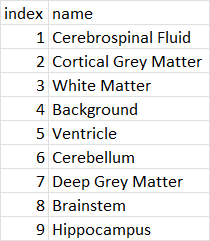

In [2]:
segments = [
    "Cerebrospinal Fluid",
    "Cortical Grey Matter",
    "White Matter",
    "Background",
    "Ventricle",
    "Cerebelum",
    "Deep Grey Matter",
    "Brainstem",
    "Hippocampus"
]

### Import Libraries

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import torch.distributions as dist
from torchsummary import summary
import math
import os
import numpy as np
import time
import matplotlib.pyplot as plt
from prettytable import PrettyTable
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from pathlib import Path
import re
from skimage.metrics  import structural_similarity as ssim
import plotly.io as pio
import plotly.express as px
import pandas as pd

pio.renderers.default = 'iframe'

from importlib import reload


# locals
import model_architectures
import visualization
import unet

reload(model_architectures)
from model_architectures import VAESegment, Data3DSingleSegToSingleSeg, SegMaskData

reload(unet)
from unet import UNet

reload(visualization)
from visualization import brain_diff, viz_slices

C:\compute\envs\torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define Paths

In [4]:
research_dir = r"D:/school/research"
code_dir = os.path.join(research_dir, "code")
model_dir = os.path.join(code_dir, "explore_again", "models")
data_dir = os.path.join(research_dir, "data")
dhcp_rel2 = os.path.join(data_dir, "dhcp_rel2")
processed_dir = os.path.join(dhcp_rel2, "processed")
volume_dir = os.path.join(processed_dir, "volumes")
seg_dir = os.path.join(processed_dir, "segments")
seg_vol_dir = os.path.join(processed_dir, "volume_segments")
pred_dir = os.path.join(dhcp_rel2, "predictions")
seg_pred_dir = os.path.join(pred_dir, "vae_9seg")

l1_dir = os.path.join(volume_dir, "l1")
l5_dir = os.path.join(volume_dir, "l5")

l1_seg_dir = os.path.join(seg_dir, "l1")
l5_seg_dir = os.path.join(seg_dir, "l5")

l1_seg_vol_dir = os.path.join(seg_vol_dir, "l1")
l5_seg_vol_dir = os.path.join(seg_vol_dir, "l5")

l1_seg_pred_dir = os.path.join(seg_pred_dir, "l1")
l5_seg_pred_dir = os.path.join(seg_pred_dir, "l5")

### Define Data Parameters

In [5]:
np.random.seed(42)
num_samples = int(len(os.listdir(l1_dir)) / 2)
samples = np.array([i for i in range(0, num_samples)])
np.random.shuffle(samples)

split_val = int(0.8 * num_samples)
train_indices = samples[0:split_val]
val_indices = samples[split_val:]

num_test = int(len(os.listdir(l5_dir)) / 2)
test_indices = np.array([i for i in range(0, num_test)])

### Train Models for Each Segment

In [15]:
for segment_number in range(0, len(segments)):
    print(f"Train model for segment {segment_number}")
    
    # Load data for segment
    train = Data3DSingleSegToSingleSeg(l1_dir, l1_seg_vol_dir, train_indices, segment=segment_number)
    val = Data3DSingleSegToSingleSeg(l1_dir, l1_seg_vol_dir, val_indices, segment=segment_number)
    test = Data3DSingleSegToSingleSeg(l5_dir, l5_seg_vol_dir, test_indices, segment=segment_number)

    batch_size = 1
    train_loader = DataLoader(train, batch_size=batch_size)#, num_workers=1)
    val_loader = DataLoader(val, batch_size=batch_size)#, num_workers=1)
    
    # Define output paths now :)
    model_path = os.path.join(model_dir, f"vae_rel2t2_seg_to_seg{segment_number}.pt")
    
    # Define the model
    model = VAESegment(1, 1)
    model.cuda()
    criterion = nn.MSELoss()
    learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, eps=1e-07)
    
    # Train the model
    num_epochs = 10
    for epoch in range(num_epochs):
        total_loss = 0
        with tqdm(train_loader, unit="batch", ascii=' >=') as tepoch:
            model.train()
            data_counter = 0
            for data in tepoch:
                # clear gradients
                optimizer.zero_grad()

                # forward
                x = data.cuda()
                output = model(x)
                loss = criterion(x, output)

                # backward
                loss.backward()
                optimizer.step()

                total_loss += loss.data
                data_counter += 1

            total_loss /= data_counter

            tepoch.set_postfix(loss=loss.item())
            val_loss = 0
            model.eval()
            data_counter = 0
            for data in val_loader:
                with torch.no_grad():
                    x = data.cuda()
                    output = model(x)
                    loss = criterion(x, output)

                    val_loss += loss.data
                    data_counter += 1
            
            val_loss /= data_counter
            
            print('epoch [{}/{}], train_loss:{:.4f}, val_loss:{:.4f}'
              .format(epoch+1, num_epochs, total_loss, val_loss))
        
    torch.save(model.state_dict(), model_path)

Train model for segment 0


100%|=============================================================================| 166/166 [02:02<00:00,  1.35batch/s]


epoch [1/10], train_loss:0.0614, val_loss:0.0088


100%|=============================================================================| 166/166 [01:56<00:00,  1.42batch/s]


epoch [2/10], train_loss:0.0079, val_loss:0.0073


100%|=============================================================================| 166/166 [01:57<00:00,  1.41batch/s]


epoch [3/10], train_loss:0.0070, val_loss:0.0067


100%|=============================================================================| 166/166 [01:58<00:00,  1.40batch/s]


epoch [4/10], train_loss:0.0065, val_loss:0.0064


100%|=============================================================================| 166/166 [01:54<00:00,  1.44batch/s]


epoch [5/10], train_loss:0.0063, val_loss:0.0062


100%|=============================================================================| 166/166 [01:55<00:00,  1.44batch/s]


epoch [6/10], train_loss:0.0061, val_loss:0.0061


100%|=============================================================================| 166/166 [01:55<00:00,  1.44batch/s]


epoch [7/10], train_loss:0.0060, val_loss:0.0060


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [8/10], train_loss:0.0060, val_loss:0.0060


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [9/10], train_loss:0.0059, val_loss:0.0060


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [10/10], train_loss:0.0059, val_loss:0.0059
Train model for segment 1


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [1/10], train_loss:0.0552, val_loss:0.0043


100%|=============================================================================| 166/166 [01:59<00:00,  1.38batch/s]


epoch [2/10], train_loss:0.0038, val_loss:0.0036


100%|=============================================================================| 166/166 [01:56<00:00,  1.42batch/s]


epoch [3/10], train_loss:0.0034, val_loss:0.0033


100%|=============================================================================| 166/166 [01:54<00:00,  1.45batch/s]


epoch [4/10], train_loss:0.0031, val_loss:0.0031


100%|=============================================================================| 166/166 [01:54<00:00,  1.45batch/s]


epoch [5/10], train_loss:0.0030, val_loss:0.0030


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [6/10], train_loss:0.0030, val_loss:0.0030


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [7/10], train_loss:0.0029, val_loss:0.0030


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [8/10], train_loss:0.0029, val_loss:0.0029


100%|=============================================================================| 166/166 [01:59<00:00,  1.38batch/s]


epoch [9/10], train_loss:0.0029, val_loss:0.0029


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [10/10], train_loss:0.0029, val_loss:0.0029
Train model for segment 2


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [1/10], train_loss:0.1049, val_loss:0.0063


100%|=============================================================================| 166/166 [02:00<00:00,  1.38batch/s]


epoch [2/10], train_loss:0.0057, val_loss:0.0051


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [3/10], train_loss:0.0050, val_loss:0.0048


100%|=============================================================================| 166/166 [01:59<00:00,  1.38batch/s]


epoch [4/10], train_loss:0.0047, val_loss:0.0048


100%|=============================================================================| 166/166 [01:59<00:00,  1.38batch/s]


epoch [5/10], train_loss:0.0046, val_loss:0.0051


100%|=============================================================================| 166/166 [01:59<00:00,  1.38batch/s]


epoch [6/10], train_loss:0.0045, val_loss:0.0053


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [7/10], train_loss:0.0045, val_loss:0.0050


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [8/10], train_loss:0.0044, val_loss:0.0049


100%|=============================================================================| 166/166 [02:00<00:00,  1.38batch/s]


epoch [9/10], train_loss:0.0044, val_loss:0.0049


100%|=============================================================================| 166/166 [01:59<00:00,  1.38batch/s]


epoch [10/10], train_loss:0.0044, val_loss:0.0051
Train model for segment 3


100%|=============================================================================| 166/166 [01:55<00:00,  1.44batch/s]


epoch [1/10], train_loss:0.0755, val_loss:0.0012


100%|=============================================================================| 166/166 [01:55<00:00,  1.43batch/s]


epoch [2/10], train_loss:0.0009, val_loss:0.0007


100%|=============================================================================| 166/166 [02:00<00:00,  1.38batch/s]


epoch [3/10], train_loss:0.0006, val_loss:0.0005


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [4/10], train_loss:0.0005, val_loss:0.0005


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [5/10], train_loss:0.0005, val_loss:0.0004


100%|=============================================================================| 166/166 [01:59<00:00,  1.38batch/s]


epoch [6/10], train_loss:0.0004, val_loss:0.0004


100%|=============================================================================| 166/166 [02:00<00:00,  1.38batch/s]


epoch [7/10], train_loss:0.0004, val_loss:0.0004


100%|=============================================================================| 166/166 [01:59<00:00,  1.38batch/s]


epoch [8/10], train_loss:0.0004, val_loss:0.0004


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [9/10], train_loss:0.0004, val_loss:0.0004


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [10/10], train_loss:0.0004, val_loss:0.0004
Train model for segment 4


100%|=============================================================================| 166/166 [01:59<00:00,  1.38batch/s]


epoch [1/10], train_loss:0.0295, val_loss:0.0012


100%|=============================================================================| 166/166 [01:58<00:00,  1.40batch/s]


epoch [2/10], train_loss:0.0010, val_loss:0.0009


100%|=============================================================================| 166/166 [01:59<00:00,  1.38batch/s]


epoch [3/10], train_loss:0.0008, val_loss:0.0008


100%|=============================================================================| 166/166 [01:59<00:00,  1.38batch/s]


epoch [4/10], train_loss:0.0007, val_loss:0.0007


100%|=============================================================================| 166/166 [02:00<00:00,  1.38batch/s]


epoch [5/10], train_loss:0.0007, val_loss:0.0007


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [6/10], train_loss:0.0007, val_loss:0.0007


100%|=============================================================================| 166/166 [02:03<00:00,  1.35batch/s]


epoch [7/10], train_loss:0.0006, val_loss:0.0007


100%|=============================================================================| 166/166 [02:00<00:00,  1.38batch/s]


epoch [8/10], train_loss:0.0006, val_loss:0.0006


100%|=============================================================================| 166/166 [01:59<00:00,  1.38batch/s]


epoch [9/10], train_loss:0.0006, val_loss:0.0006


100%|=============================================================================| 166/166 [02:01<00:00,  1.37batch/s]


epoch [10/10], train_loss:0.0006, val_loss:0.0006
Train model for segment 5


100%|=============================================================================| 166/166 [02:00<00:00,  1.38batch/s]


epoch [1/10], train_loss:0.0206, val_loss:0.0008


100%|=============================================================================| 166/166 [02:01<00:00,  1.37batch/s]


epoch [2/10], train_loss:0.0006, val_loss:0.0005


100%|=============================================================================| 166/166 [01:59<00:00,  1.38batch/s]


epoch [3/10], train_loss:0.0004, val_loss:0.0004


100%|=============================================================================| 166/166 [01:59<00:00,  1.38batch/s]


epoch [4/10], train_loss:0.0004, val_loss:0.0004


100%|=============================================================================| 166/166 [02:00<00:00,  1.38batch/s]


epoch [5/10], train_loss:0.0003, val_loss:0.0003


100%|=============================================================================| 166/166 [02:00<00:00,  1.38batch/s]


epoch [6/10], train_loss:0.0003, val_loss:0.0003


100%|=============================================================================| 166/166 [02:00<00:00,  1.38batch/s]


epoch [7/10], train_loss:0.0003, val_loss:0.0003


100%|=============================================================================| 166/166 [02:00<00:00,  1.38batch/s]


epoch [8/10], train_loss:0.0003, val_loss:0.0003


100%|=============================================================================| 166/166 [02:00<00:00,  1.38batch/s]


epoch [9/10], train_loss:0.0003, val_loss:0.0003


100%|=============================================================================| 166/166 [02:01<00:00,  1.37batch/s]


epoch [10/10], train_loss:0.0003, val_loss:0.0003
Train model for segment 6


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [1/10], train_loss:0.0544, val_loss:0.0011


100%|=============================================================================| 166/166 [01:56<00:00,  1.42batch/s]


epoch [2/10], train_loss:0.0008, val_loss:0.0006


100%|=============================================================================| 166/166 [01:55<00:00,  1.43batch/s]


epoch [3/10], train_loss:0.0005, val_loss:0.0004


100%|=============================================================================| 166/166 [01:54<00:00,  1.45batch/s]


epoch [4/10], train_loss:0.0004, val_loss:0.0004


100%|=============================================================================| 166/166 [01:55<00:00,  1.43batch/s]


epoch [5/10], train_loss:0.0003, val_loss:0.0003


100%|=============================================================================| 166/166 [01:55<00:00,  1.43batch/s]


epoch [6/10], train_loss:0.0003, val_loss:0.0003


100%|=============================================================================| 166/166 [01:55<00:00,  1.44batch/s]


epoch [7/10], train_loss:0.0003, val_loss:0.0003


100%|=============================================================================| 166/166 [02:00<00:00,  1.37batch/s]


epoch [8/10], train_loss:0.0003, val_loss:0.0003


100%|=============================================================================| 166/166 [01:57<00:00,  1.41batch/s]


epoch [9/10], train_loss:0.0003, val_loss:0.0003


100%|=============================================================================| 166/166 [01:59<00:00,  1.38batch/s]


epoch [10/10], train_loss:0.0003, val_loss:0.0002
Train model for segment 7


100%|=============================================================================| 166/166 [02:00<00:00,  1.37batch/s]


epoch [1/10], train_loss:0.0101, val_loss:0.0003


100%|=============================================================================| 166/166 [02:01<00:00,  1.37batch/s]


epoch [2/10], train_loss:0.0002, val_loss:0.0002


100%|=============================================================================| 166/166 [01:58<00:00,  1.40batch/s]


epoch [3/10], train_loss:0.0002, val_loss:0.0001


100%|=============================================================================| 166/166 [02:01<00:00,  1.36batch/s]


epoch [4/10], train_loss:0.0001, val_loss:0.0001


100%|=============================================================================| 166/166 [02:00<00:00,  1.38batch/s]


epoch [5/10], train_loss:0.0001, val_loss:0.0001


100%|=============================================================================| 166/166 [02:01<00:00,  1.37batch/s]


epoch [6/10], train_loss:0.0001, val_loss:0.0001


100%|=============================================================================| 166/166 [02:00<00:00,  1.37batch/s]


epoch [7/10], train_loss:0.0001, val_loss:0.0001


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [8/10], train_loss:0.0001, val_loss:0.0001


100%|=============================================================================| 166/166 [02:02<00:00,  1.36batch/s]


epoch [9/10], train_loss:0.0001, val_loss:0.0001


100%|=============================================================================| 166/166 [02:02<00:00,  1.36batch/s]


epoch [10/10], train_loss:0.0001, val_loss:0.0001
Train model for segment 8


100%|=============================================================================| 166/166 [02:03<00:00,  1.35batch/s]


epoch [1/10], train_loss:0.0620, val_loss:0.0007


100%|=============================================================================| 166/166 [02:02<00:00,  1.35batch/s]


epoch [2/10], train_loss:0.0005, val_loss:0.0003


100%|=============================================================================| 166/166 [01:59<00:00,  1.39batch/s]


epoch [3/10], train_loss:0.0003, val_loss:0.0002


100%|=============================================================================| 166/166 [01:57<00:00,  1.42batch/s]


epoch [4/10], train_loss:0.0002, val_loss:0.0002


100%|=============================================================================| 166/166 [02:02<00:00,  1.36batch/s]


epoch [5/10], train_loss:0.0001, val_loss:0.0001


100%|=============================================================================| 166/166 [02:01<00:00,  1.37batch/s]


epoch [6/10], train_loss:0.0001, val_loss:0.0001


100%|=============================================================================| 166/166 [02:02<00:00,  1.36batch/s]


epoch [7/10], train_loss:0.0001, val_loss:0.0001


100%|=============================================================================| 166/166 [02:01<00:00,  1.36batch/s]


epoch [8/10], train_loss:0.0001, val_loss:0.0001


100%|=============================================================================| 166/166 [02:02<00:00,  1.35batch/s]


epoch [9/10], train_loss:0.0001, val_loss:0.0001


100%|=============================================================================| 166/166 [02:02<00:00,  1.36batch/s]


epoch [10/10], train_loss:0.0002, val_loss:0.0004


### Get High Level Visualization

In [10]:
results = []

for segment_number in range(0, len(segments)):
    print(f"Train model for segment {segment_number}")
    
    # Load data for segment
    train = Data3DSingleSegToSingleSeg(l1_dir, l1_seg_vol_dir, train_indices, segment=segment_number)
    val = Data3DSingleSegToSingleSeg(l1_dir, l1_seg_vol_dir, val_indices, segment=segment_number)
    test = Data3DSingleSegToSingleSeg(l5_dir, l5_seg_vol_dir, test_indices, segment=segment_number)

    batch_size = 1
    train_loader = DataLoader(train, batch_size=batch_size)#, num_workers=1)
    val_loader = DataLoader(val, batch_size=batch_size)#, num_workers=1)
    
    # Define output paths now :)
    model_path = os.path.join(model_dir, f"vae_rel2t2_seg_to_seg{segment_number}.pt")
    model = VAESegment(1, 1)
    model.load_state_dict(torch.load(model_path))
    model.cuda()
    model.eval()
    
    # Get predictions
    img = train[0]
    x = torch.Tensor(np.reshape(img, (1, 1, 256, 256, 256))).cuda()
    output = model(x)
    og = np.reshape(x.cpu().detach().numpy(), (256, 256, 256))
    pred = np.reshape(output.cpu().detach().numpy(), (256, 256, 256))
    
    results.append(pred)

Train model for segment 0
Train model for segment 1
Train model for segment 2
Train model for segment 3
Train model for segment 4
Train model for segment 5
Train model for segment 6
Train model for segment 7
Train model for segment 8


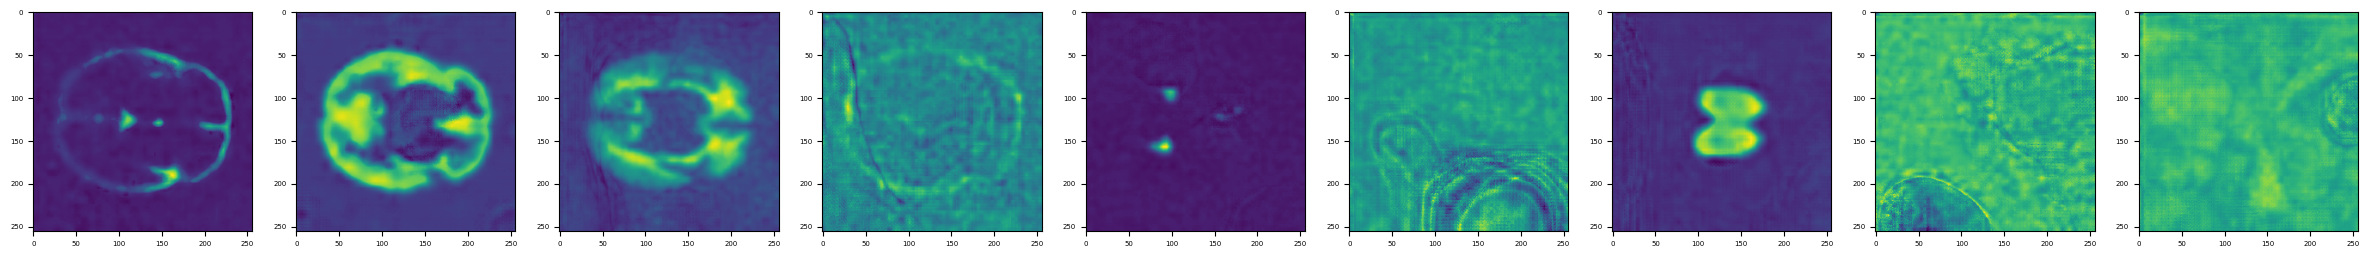

In [12]:
fig, ax = plt.subplots(1, 9, figsize=(30,20))

for i in range(0, 9):
    ax[i].imshow(results[i][:,:,128])
    ax[i].tick_params(axis='both', which='major', labelsize=5)

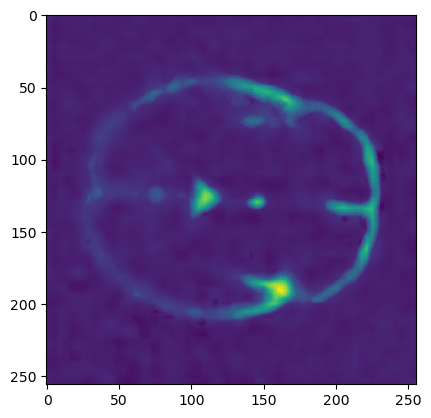

In [9]:
plt.imshow(pred[:,:,128])